In [1]:
%load_ext autoreload

%autoreload 2

import scenarion
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import copy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras import optimizers

Using TensorFlow backend.


# Description
The point here is to demonstrate how Scenarion can help demonstrate when a single feature has multiple, different relationships with the variable you'd like to predict (for different subsets of the data). This example also demonstrates how a model can give unrealistic results for out-of-sample scenarios and highlights the importance of recognizing those scenarios as out-of-sample.

# Generate the data
We'll predict athletic performance of NFL players. Our features will be what position they play and their weight.

In [2]:
# Create offensive tackle data
n_tackles = 5000
n_receivers = 4000

def tackle_performance(size, noise=50):
    x = np.linspace(-20, 10, size)
    return (500 -x**2 + np.random.randn(size)*noise)/700

weights = np.linspace(210, 400, n_tackles)
speeds = np.random.randn(len(weights))/10
performances = tackle_performance(len(weights)) + speeds

tackle_df = pd.DataFrame()
tackle_df['weight'] = weights
tackle_df['speed'] = speeds
tackle_df['performance'] = performances
tackle_df['position'] = 'offensive tackle'

# Create wide receiver data
def receiver_performance(size, noise=500):
    x = np.linspace(-10, 60, size)
    return 0.85+(-x**2 + np.random.randn(size)*noise)/5000

weights = np.linspace(165, 300, n_receivers)
speeds = np.random.randn(len(weights))/10
performances = receiver_performance(len(weights)) + speeds

receiver_df = pd.DataFrame()
receiver_df['weight'] = weights
receiver_df['speed'] = speeds
receiver_df['performance'] = performances
receiver_df['position'] = 'wide receiver'

df = pd.concat([tackle_df, receiver_df])


# view a sample of the DataFrame
df.sample(4)

,weight,speed,performance,position
3555,345.117023,-0.021906,0.893841,offensive tackle
1958,284.418884,0.162750,0.779292,offensive tackle
3200,273.027007,-0.029739,0.446260,wide receiver
3196,272.891973,-0.022465,0.266075,wide receiver


## Do one hot encoding on categorical variables

In [3]:
new_df = copy.copy(df)

dummy_data = pd.get_dummies(df['position'])

new_df = pd.concat([new_df, dummy_data], axis=1)

## Normalize data

In [4]:
for col in ['weight','offensive tackle', 'wide receiver', 'speed']:
    if set(new_df[col].unique()) <= set((0,1)):
        # don't normalize one-hot-encoded data
        continue
    new_df[col] = (new_df[col] - new_df[col].mean()) / new_df[col].std()

# Train a model

In [5]:
y_col = 'performance'
x_cols = ['weight','offensive tackle', 'wide receiver', 'speed']

train_x = new_df[x_cols]
train_y = new_df[y_col]

model = Sequential()

model.add(Dense(units=6, activation='tanh', input_dim=len(x_cols)))

model.add(Dropout(0.3))
model.add(Dense(units=6, activation='tanh'))
model.add(Dense(units=4, activation='tanh'))
model.add(Dense(units=1))

sgd = optimizers.SGD(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=sgd)

model.fit(train_x, train_y, epochs=100, verbose=0)

# Use Scenarion to interpret the model

Testing Scenarios: 100%|██████████| 100/100 [00:03<00:00, 31.15it/s]


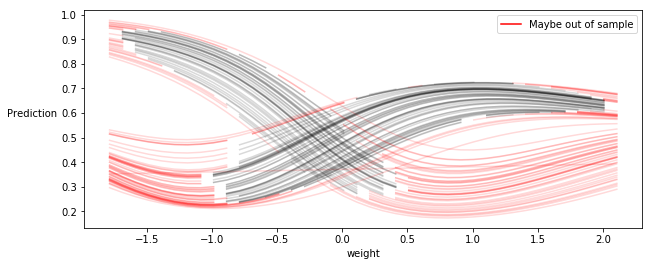

In [8]:
col_to_test = 'weight'

'''
In this example we built our model using Keras. The predict method
for keras models return something slightly different than what 
scenarion is expecting. As such, we need to quickly wrap our model
in a new class whose predict method returns something in the form
scenarion expects.
'''
class WrappedModel():
    def __init__(self, model):
        self.model = model
    
    def predict(self, x):
        return self.model.predict(x)[:,0]

    
wrapped_model = WrappedModel(model)

scenarios_df = scenarion.test_scenarios(wrapped_model, new_df, x_cols, 
                                feat_to_test=col_to_test, n_samples=100,
                                hide_oos=False)

**Figure Interpretation:** For some football players, increasing weight tends to decrease performance, while for other's increasing weight (up to a point) tends to _increase_ performance. It turns out that this can easily be explained by a player's position (wide receivers should be lighter than offensive tackles). It is also clear from the figure that we shouldn't trust the model's out-of-sample predictions. Because the model wasn't trained on any 350 pound wide recievers, it didn't learn that that would reduce performance, and for the 350 pound player's that the model _was_ trained on (tackles) that wasn't problematic. As such, the out-of-sample scenarios (in red) give unintuitive (and almost certainly innacurate) results.

Testing Scenarios: 100%|██████████| 100/100 [00:02<00:00, 34.64it/s]


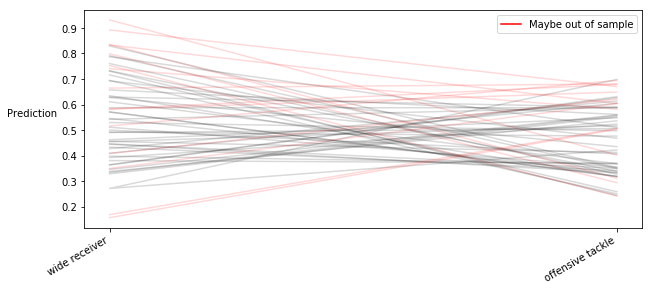

In [9]:
categorical_columns = ['wide receiver', 'offensive tackle']
scenarios_df = scenarion.test_scenarios(wrapped_model, 
                                new_df, x_cols, 
                                categorical_columns, n_samples=100,
                                hide_oos=False)